In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from tinyshift.outlier import HBOS, SPAD
from tinyshift.tracker import AnomalyTracker
from sklearn.model_selection import train_test_split

In [2]:

weights = [0.2, 0.8]

X, y = make_classification(
    n_samples=100000, 
    n_features=20, 
    n_informative=2,      
    weights=weights, 
    random_state=42,
    n_redundant=2)

num_samples = X.shape[0]

categorical_col1 = np.random.choice(['A', 'B', 'C'], size=num_samples)
categorical_col2 = np.random.choice(['X', 'Y', 'Z'], size=num_samples)

df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
df['cat1'] = categorical_col1
df['cat2'] = categorical_col2
df["cat1"] = df["cat1"].astype("category").cat.rename_categories({"A": 0, "B": 1, "C": 2})
df["cat2"] = df["cat2"].astype("category").cat.rename_categories({"Z": 0, "Y": 1, "X": 2})

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

## HBOS

In [3]:
hbos = HBOS()
hbos.fit(df_train, nbins="fd", dynamic_bins=True)

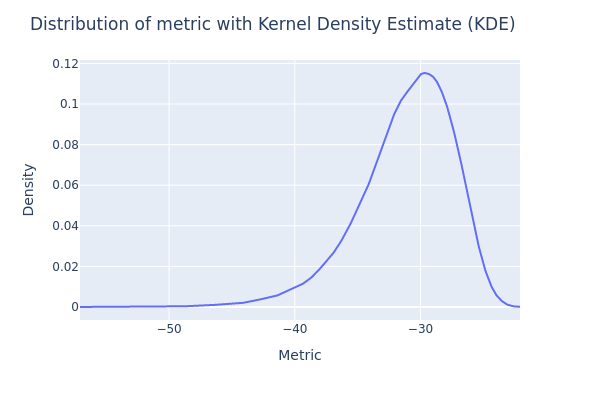

In [4]:
tracker = AnomalyTracker(hbos)
tracker.plot.kde(fig_type="png")

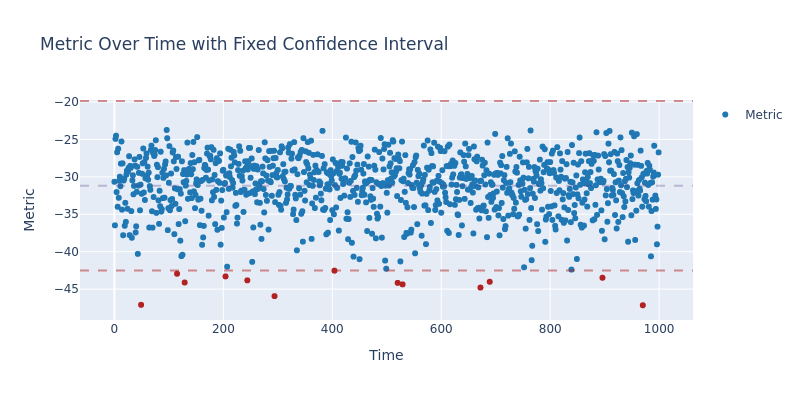

In [5]:
tracker.plot.scatter(tracker.anomaly_scores[:1000], fig_type="png")

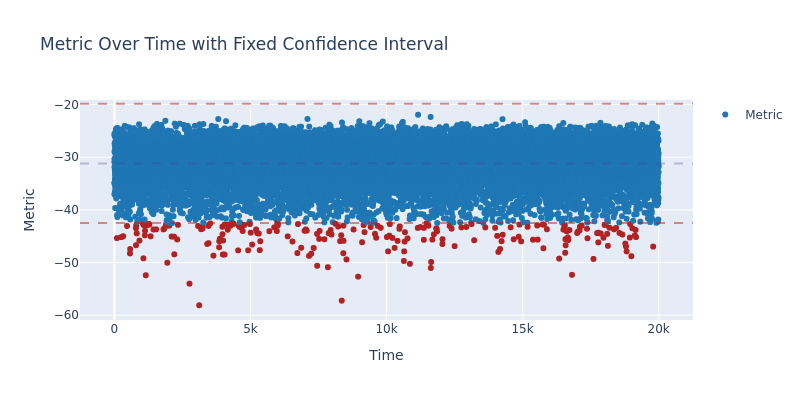

In [6]:
scored = tracker.score(df_test)
tracker.plot.scatter(scored, fig_type="png")

## SPAD

In [7]:
spad = SPAD()
spad.fit(df_train, nbins="fd", method="mad")

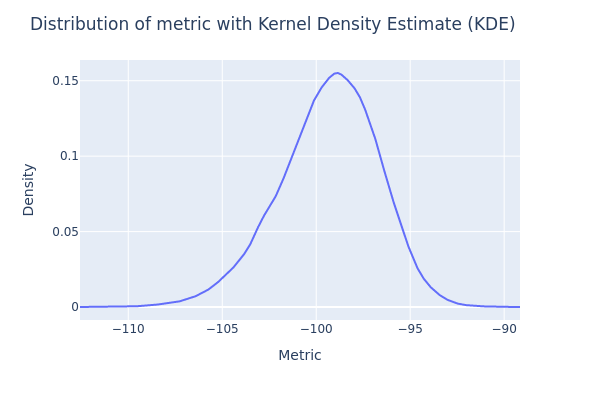

In [8]:
tracker = AnomalyTracker(spad)
tracker.plot.kde(fig_type="png")

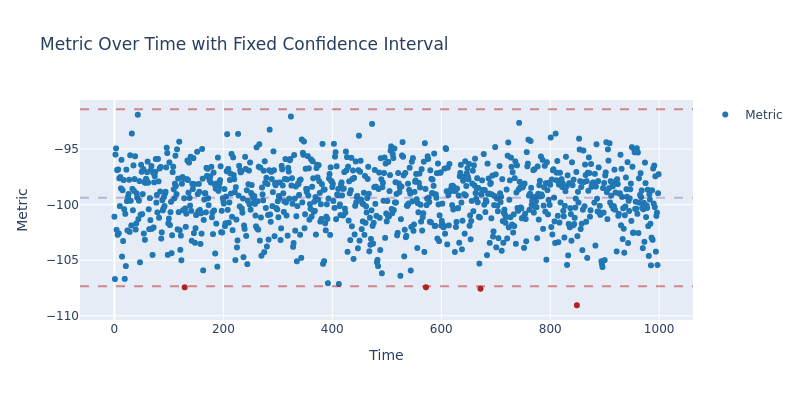

In [9]:
tracker.plot.scatter(tracker.anomaly_scores[:1000], fig_type="png")

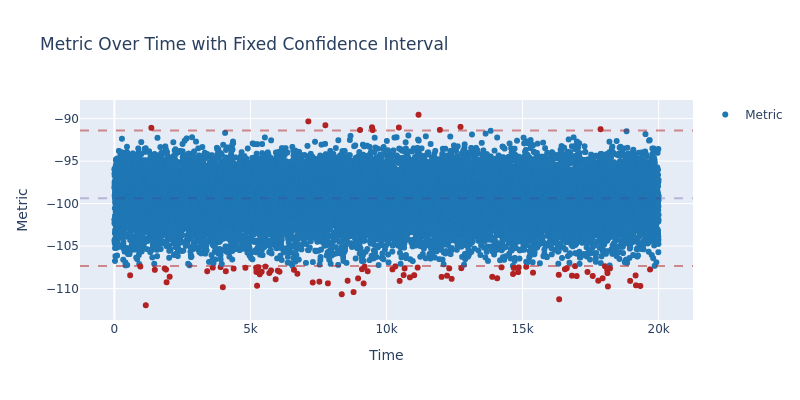

In [10]:
scored = tracker.score(df_test)
tracker.plot.scatter(scored, fig_type="png")

## SPAD+

In [11]:
spad_plus = SPAD(plus=True)
spad_plus.fit(df_train)

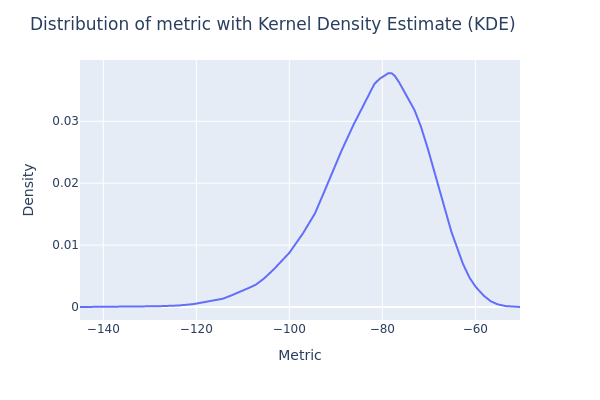

In [12]:
tracker = AnomalyTracker(spad_plus)
tracker.plot.kde(fig_type="png")

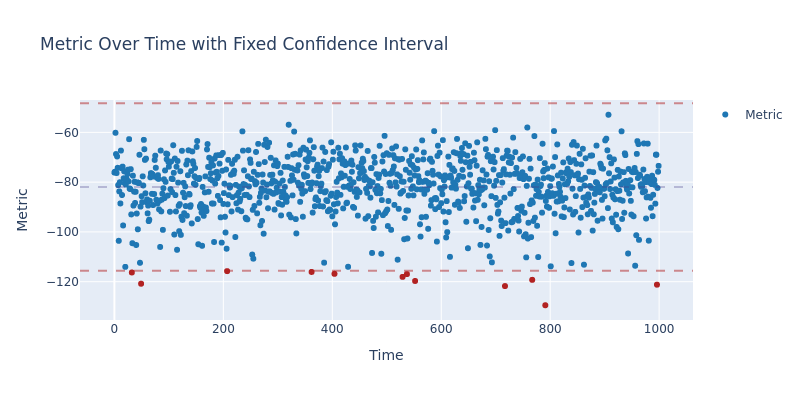

In [13]:
tracker.plot.scatter(tracker.anomaly_scores[:1000], fig_type="png")

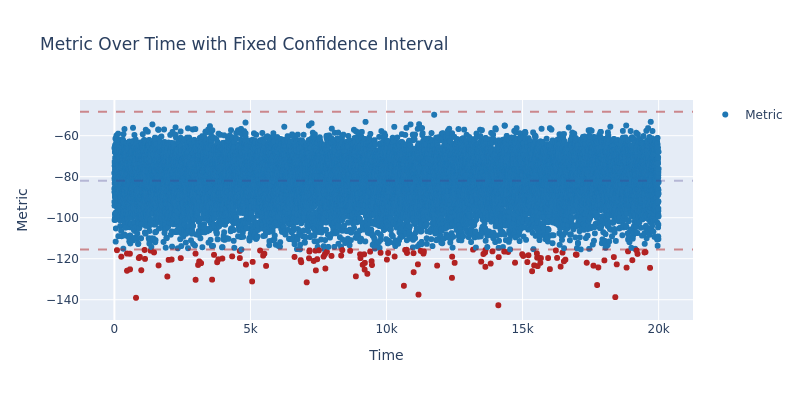

In [14]:
scored = tracker.score(df_test)
tracker.plot.scatter(scored, fig_type="png")